# Assignment AS03: Time Series Analysis

For this assignment we will perform time series analysis of a stock market dataset. 

# 0. Preliminaries

## 0.1. Dataset

The dataset we will use is contained in the file `prices-split-adjusted.csv` which contains the prices of various stock in the New York Stock Exchange. The file was downloaded from a [Kaggle dataset](https://www.kaggle.com/dgawlik/nyse).

## 0.2. Required imports

In [1]:
import io
import csv
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 0.3. Load the data

We load the data using a csv [DictReader](https://docs.python.org/2/library/csv.html#reader-objects) which we then convert to a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). We are not using Pandas' methods for loading CSV files because we want to control each and every aspect of the conversion.

In [2]:
INPUT_FILE = 'Datasets/prices-split-adjusted.csv'
data_matrix = []

# Tech stocks with market cap >= 10^9 dollars 
# Source https://finance.yahoo.com/u/yahoo-finance/watchlists/tech-stocks-that-move-the-market/
tech_stocks = set(['MSFT', 'NVDA', 'PYPL', 'EA', 'INTC', 'GOOG', 'FB', 'ATVI', 'AMZN', 'AAPL', 'CRM'])

with io.open(INPUT_FILE) as file:
    reader = csv.DictReader(file, delimiter=',')
    for row in reader:
        symbol = row['symbol']
        if symbol in tech_stocks:
            date = datetime.datetime.strptime(row['date'], '%Y-%m-%d')
            price = float(row['open'])
            datum = { 'date': date, 'symbol': symbol, 'price': price }
            data_matrix.append(datum)
            
df = pd.DataFrame(data_matrix, columns=['date', 'symbol', 'price'])

Inspect the data. This is always useful when loading a new dataset.

In [3]:
for symbol in set(df.symbol):
    min_date = np.min(df.loc[df['symbol'] == symbol])['date']
    max_date = np.max(df.loc[df['symbol'] == symbol])['date']
    price = df.loc[df['symbol'] == symbol]['price']
    print("%6s from %s to %s, %d datapoints" % (symbol, min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'), len(price)))  

  PYPL from 2015-07-06 to 2016-12-30, 378 datapoints
    FB from 2013-01-02 to 2016-12-30, 1008 datapoints
  ATVI from 2010-01-04 to 2016-12-30, 1762 datapoints
  AMZN from 2010-01-04 to 2016-12-30, 1762 datapoints
  MSFT from 2010-01-04 to 2016-12-30, 1762 datapoints
  GOOG from 2010-01-04 to 2016-12-30, 1762 datapoints
    EA from 2010-01-04 to 2016-12-30, 1762 datapoints
  NVDA from 2010-01-04 to 2016-12-30, 1762 datapoints
  INTC from 2010-01-04 to 2016-12-30, 1762 datapoints
  AAPL from 2010-01-04 to 2016-12-30, 1762 datapoints
   CRM from 2010-01-04 to 2016-12-30, 1762 datapoints


Now let's plot one stock.

C:\Users\roger\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


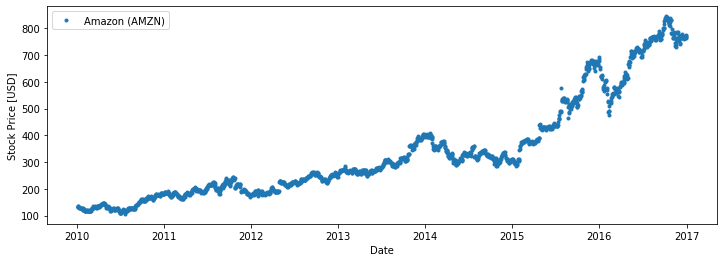

In [4]:
amazon = df.loc[df['symbol'] == 'AMZN'].set_index('date')

plt.figure(figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('Stock Price [USD]')
plt.plot_date(amazon.index, amazon['price'], '.', label='Amazon (AMZN)' )
plt.legend()
plt.show()

# 1. Perform multi-step forecasting with an AR model

We will now create an *auto-regressive* model, similarly to what we did in the practice. Select one stock and store it in the variable `price_series`. Select three values for the lag.

[**REPORT**] Indicate which stock did you choose and how did you choose your three values for the lag.

In [5]:
# Choose one stock in the next line
SYMBOL = 'AMZN'

price_series = df.loc[df['symbol'] == SYMBOL].set_index('date')

# Choose your own lags: do not use the same as these

#Done in the end-to-end part, last cells of the Assigment
LAGS = [1, 3, 7]

## 1.1. Create an AR model.

Use the `prepare_matrices(series, lags)` function you created during one of the practice sessions. When doing the linear regression, you will have an X matrix of 3 columns (because we are using three lags) and a vector y.

In [6]:
def prepare_matrices(series, lags):
    # YOUR CODE HERE, can be the same from the time series practice
    y = []
    X = []
    
    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    
    for i in range(np.max(lags), len(series)):
        row = []
        # YOUR CODE HERE
        for lag in lags:
            row.append(series[i-lag])
            
        X.append(row)
        y.append(series[i])
        
    return X, y

In [7]:
ar_X, ar_y = prepare_matrices(price_series['price'], LAGS)
print("Matrix ar_X has %d rows and %d columns" % np.shape(ar_X))
print("Vector ar_y has %d components" % np.shape(ar_y)[0])
assert(len(np.shape(ar_y)) == 1) # Check that y is a vector

Matrix ar_X has 1755 rows and 3 columns
Vector ar_y has 1755 components


Split this into two parts: training and testing, using a split point.

In [8]:
# Define your own split point
SPLIT_POINT = 1400

# Function to perform the split
def split_train_test(X, y, split_point):
    assert(split_point < np.shape(X)[0])
    # YOUR CODE HERE to split X and y
    # train_X and train_y should contain the first split_point rows
    # test_X and test_y should contain the remaining rows
    train_X = X[:split_point]
    train_y = y[:split_point]
    test_X = X[split_point:]
    test_y = y[split_point:]
    return train_X, train_y, test_X, test_y
        
ar_train_X, ar_train_y, ar_test_X, ar_test_y = split_train_test(ar_X, ar_y, SPLIT_POINT)

print("Training X has %d rows and %d columns" % np.shape(ar_train_X))
print("Training y has %d components" % np.shape(ar_train_y)[0])

print("Testing X has %d rows and %d columns" % np.shape(ar_test_X))
print("Testing y has %d components" % np.shape(ar_test_y)[0])

Training X has 1400 rows and 3 columns
Training y has 1400 components
Testing X has 355 rows and 3 columns
Testing y has 355 components


Now perform the linear regression for fitting this *AR* model using the training part, and print the resulting MSE (mean squared error) with respect to the testing part.

In [9]:
ar_model = LinearRegression()
ar_model.fit(ar_train_X, ar_train_y)
ar_test_y_pred = ar_model.predict(ar_test_X)
ar_mse = mean_squared_error(ar_test_y_pred, ar_test_y)
print("MSE of AR model: %.4f" % ar_mse)

MSE of AR model: 140.0308


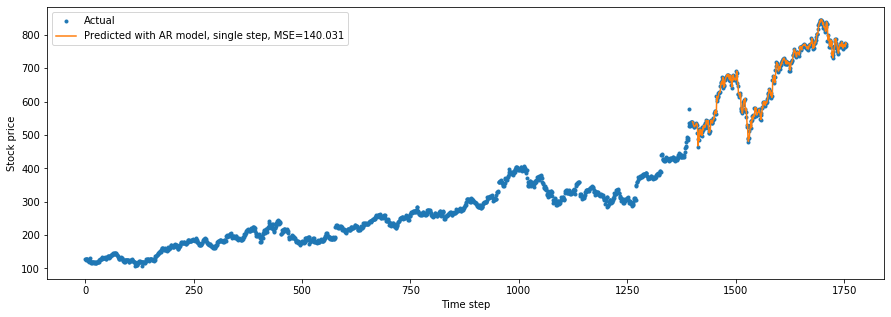

In [10]:
plt.figure(figsize=(15,5))
plt.plot(range(len(ar_y)), ar_y, '.', label='Actual')
plt.plot(range(SPLIT_POINT, len(ar_y)), ar_test_y_pred, '-', label='Predicted with AR model, single step, MSE=%.3f' % ar_mse)
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.legend()
plt.show()

Let us zoom into the values around the split point.

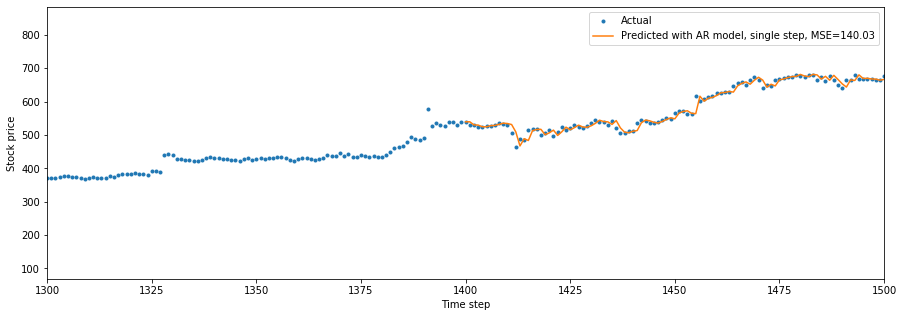

In [11]:
plt.figure(figsize=(15,5))
plt.plot(range(len(ar_y)), ar_y, '.', label='Actual')
plt.plot(range(SPLIT_POINT, len(ar_y)), ar_test_y_pred, '-', label='Predicted with AR model, single step, MSE=%.2f' % ar_mse)
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.legend()
plt.xlim(SPLIT_POINT-100, SPLIT_POINT+100)
plt.show()

## 1.2. Perform multi-step forecasting using this model

So far we are performing one-step forecasting, looking in this case one day into the future, but we can forecast several steps into the future. This naturally yields a worse prediction that gets worse the farther we are into the future.

Multi-step forecasting is done as follows: first, one creates a model, then one feeds the output of this model as future data to the same model.

We need to re-implement the `predict()` method. For that, we need to know the formula that we learned:

In [12]:
coeff = ar_model.coef_
intercept = ar_model.intercept_

print("Formula: y[i] = %f * y[i-%d] + %f * y[i-%d] + %f * y[i-%d] + %f" % (coeff[0], LAGS[0], coeff[1], LAGS[1], coeff[2], LAGS[2], intercept))

Formula: y[i] = 0.956699 * y[i-1] + 0.048840 * y[i-3] + -0.004375 * y[i-7] + 0.016445


Create code for computing this formula from a row in X and check that it is correct. Note that, if the first lag is r, the value of the series y[i-r] is stored in x[0]. If the second lag is s, the value of the series y[i-s] is stored in x[1], and so on.

In [13]:
def my_predict(x):
    # YOUR CODE HERE to compute the formula above given a vector x
    
    #general case, if x has more than 3 values
    result = intercept
    for value in range(len(x)):
        result += coeff[value] * x[value]
    
    #result = coeff[0] * x[0] + coeff[1] * x[1] + coeff[2] * x[2] + intercept
    return result

ar_test_y_pred = ar_model.predict(ar_test_X)
ar_test_y_pred_mine = [my_predict(x) for x in ar_test_X ]

for (theirs, mine) in zip(ar_test_y_pred, ar_test_y_pred_mine):
    assert( abs(theirs - mine) < 0.01 )

In [14]:
ar_test_y_pred_multistep = []

for i in range(len(ar_test_X)):
    x = []
    # YOUR CODE HERE
    for j in range(len(LAGS)):
        if i-LAGS[j] >= 0:
            x.append(ar_test_y_pred_multistep[i-LAGS[j]])
        else:            
            x.append(my_predict(ar_test_X[i]))
    ar_test_y_pred_multistep.append(my_predict(x))  
ar_multistep_mse = mean_squared_error(ar_test_y, ar_test_y_pred_multistep)

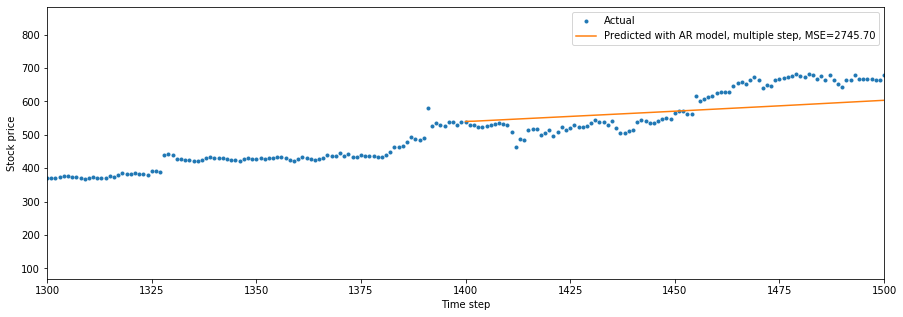

In [15]:
plt.figure(figsize=(15,5))
plt.plot(range(len(ar_y)), ar_y, '.', label='Actual')
plt.plot(range(SPLIT_POINT, len(ar_y)), ar_test_y_pred_multistep, '-', label='Predicted with AR model, multiple step, MSE=%.2f' % ar_multistep_mse)
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.legend()
plt.xlim(SPLIT_POINT-100, SPLIT_POINT+100)
plt.show()

# 2. Create an auto-regressive moving-averages model

We will now create an *ARMA* model. Start by creating an AR(2) model. In this model, you use the following lags: `[1, 2]`. When doing the linear regression, you will have an X matrix of 2 columns and a vector y. The first column will contain the price series lagged one timestep, the second column will contain the price series lagged two timesteps.

## 2.1. Create an AR(2) model

[**CODE**] Include here code to create your AR(2) model. We will **not** perform a training/testing split this time to keep things simple.

In [16]:
ar_X, ar_y = prepare_matrices(price_series['price'], [1,2])
print("Matrix ar_X has %d rows and %d columns" % np.shape(ar_X))
print("Vector ar_y has %d components" % np.shape(ar_y)[0])
assert(len(np.shape(ar_y)) == 1) # Check that y is a vector

Matrix ar_X has 1760 rows and 2 columns
Vector ar_y has 1760 components


In [17]:
ar_model = LinearRegression()
ar_model.fit(ar_X, ar_y)
ar_y_pred = ar_model.predict(ar_X)
ar_mse = mean_squared_error(ar_y_pred, ar_y)
print("MSE of AR model: %.4f" % ar_mse)

MSE of AR model: 54.0319


Note that you cannot compare this error to the error of the previous model, as this error has not been evaluated on a separate test set.

## 2.1. Create an ARMA(2,2) model

Compute the errors of the AR model as `ar_errors = y_pred - y`. Then, create new matrices (arma_X, arma_y), where matrix arma_X has now four columns. The two additional columns with respect to ar_X are the errors of the AR model 1 timestep before, and the errors of the AR model 2 timesteps before. This will also reduce the number of rows in arma_X and arma_y with respect to ar_X and ar_y by two units.

In [18]:
ar_errors = ar_y_pred - ar_y
arma_X = []
arma_y = []
for i in range(len(ar_X)):    
    # YOUR CODE HERE to create arma_X and arma_y
    # You will have to use the variables
    # ar_X[i][0], ar_X[i][1], ar_errors[i-1], ar_errors[i-2] for arma_X
    # ar_y[i] for arma_y
    if i >= 2:
        prev_error = ar_errors[i-1]
        prev_prev_error = ar_errors[i-2]
        arma_X.append([ar_X[i][0],ar_X[i][1], prev_error, prev_prev_error])
        arma_y.append(ar_y[i])
    
print("Matrix arma_X has %d rows and %d columns" % np.shape(arma_X))
print("Vector arma_y has %d components" % np.shape(arma_y)[0])
assert(len(np.shape(arma_y)) == 1) # Check that y is a vector

Matrix arma_X has 1758 rows and 4 columns
Vector arma_y has 1758 components


Fit this ARMA(2,2) model and plot its mean squared error.

In [19]:
arma_model = LinearRegression()
arma_model.fit(arma_X,arma_y)
arma_y_pred = arma_model.predict(arma_X)
arma_mse = mean_squared_error(arma_y_pred, arma_y)
print("MSE of ARMA model: %.4f" % arma_mse)

MSE of ARMA model: 53.9488


You should obtain an ARMA(2,2) model that is slightly better (i.e., has slightly lower MSE) than the AR(2) model.

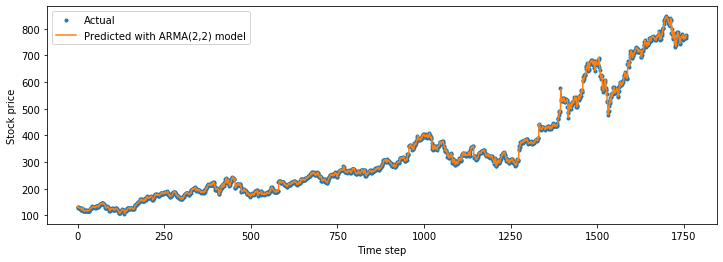

In [20]:
plt.figure(figsize=(12,4))
plt.plot(range(len(arma_y)), arma_y, '.', label='Actual')
plt.plot(range(len(arma_y_pred)), arma_y_pred, '-', label='Predicted with ARMA(2,2) model')
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.legend()
plt.show()

# 3. Exploit cross-correlations to improve your ARMA model

Notice that companies in this sector are interrelated. This means that the performance of their stock follows similar patterns. We can compare two stocks by performing an *inner join* on an index column (*date*). The inner join selects only data rows in the intersection of dates for both datasets. In other words, it selects only the dates for which we have prices in both stocks.

In [21]:
# Intel stock
pypl = df.loc[df['symbol'] == 'INTC']

# Microsoft stock
msft = df.loc[df['symbol'] == 'MSFT']

dfsel = pypl.set_index('date').join(msft.set_index('date'), how='inner', lsuffix='_intc', rsuffix='_msft')

Plotting these stocks reveals that there is substantial cross-correlation between them.

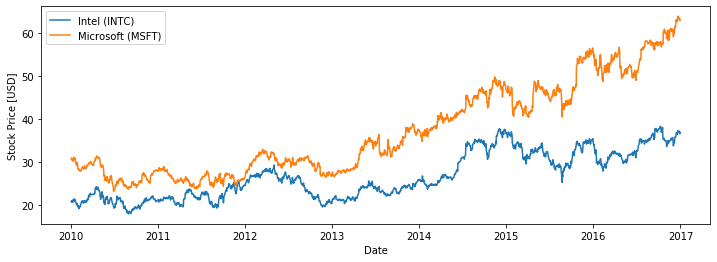

In [22]:
plt.figure(figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('Stock Price [USD]')
plt.plot_date(dfsel.index, dfsel['price_intc'], '-', label='Intel (INTC)' )
plt.plot_date(dfsel.index, dfsel['price_msft'], '-', label='Microsoft (MSFT)')
plt.legend()
plt.show()

In [23]:
print("Correlation: %.2f" % stats.pearsonr(dfsel['price_intc'], dfsel['price_msft'])[0])

Correlation: 0.91


## 3.1. Find two stocks that are highly correlated

[**CODE**] Compute Pearson's correlation between all pairs of stock. Find two stock that are highly correlated.

[**REPORT**] Include a matrix with all correlations between pairs of stock in your report. Is there a stock that is consistently less correlated with the other stock? Which one? Tip: you will need to an inner join to ensure vectors are of the same length before calling `stats.pearsonr(priceA, priceB)`, and remember that this function returns a vector, the correlation is in `stats.pearsonR(priceA,priceB)[0]`. For instance, the correlation between GOOG and EA it is 0.89 and between EA and FB it is 0.94.

In [24]:
correlation_df = pd.DataFrame(columns=df.symbol.unique(), index=df.symbol.unique())
for symbol1 in set(df.symbol):
    # YOUR CODE HERE
    company1 = df.loc[df['symbol'] == symbol1]
    for symbol2 in set(df.symbol):
        # YOUR CODE HERE
        company2 = df.loc[df['symbol'] == symbol2]
        company_join = company1.set_index('date').join(company2.set_index('date'), how='inner', lsuffix='_1', rsuffix='_2')
        correlation = stats.pearsonr(company_join['price_1'], company_join['price_2'])[0]
        correlation_df.loc[symbol1][symbol2] = float(correlation)
        if symbol1 != symbol2:
            if random.randrange(10) == 1:
                print("%6s vs %6s: %.2f" % (symbol1, symbol2, correlation))
    row = []

  PYPL vs     FB: 0.69
  PYPL vs   INTC: 0.45
  ATVI vs   INTC: 0.82
  ATVI vs    CRM: 0.90
  MSFT vs   NVDA: 0.76
  MSFT vs    CRM: 0.91
  GOOG vs   INTC: 0.82
  NVDA vs    CRM: 0.62
  AAPL vs   NVDA: 0.47
  AAPL vs   INTC: 0.86
   CRM vs   GOOG: 0.95


In [25]:
#EXTRA
display(correlation_df)

,AAPL,AMZN,ATVI,CRM,EA,GOOG,INTC,MSFT,NVDA,FB,PYPL
AAPL,1,0.733582,0.72802,0.864347,0.772738,0.78854,0.86357,0.818037,0.473299,0.743725,0.156467
AMZN,0.733582,1,0.974866,0.908436,0.925862,0.939746,0.763536,0.917099,0.825016,0.899572,0.546589
ATVI,0.72802,0.974866,1,0.904321,0.956102,0.943251,0.815184,0.944949,0.8029,0.944944,0.401416
CRM,0.864347,0.908436,0.904321,1,0.898044,0.945454,0.815254,0.909811,0.617515,0.926694,0.13328
EA,0.772738,0.925862,0.956102,0.898044,1,0.892671,0.823758,0.923135,0.764037,0.939731,0.522865
GOOG,0.78854,0.939746,0.943251,0.945454,0.892671,1,0.81753,0.957641,0.708291,0.943448,0.520757
INTC,0.86357,0.763536,0.815184,0.815254,0.823758,0.81753,1,0.908215,0.634165,0.803029,0.447452
MSFT,0.818037,0.917099,0.944949,0.909811,0.923135,0.957641,0.908215,1,0.762978,0.946726,0.576495
NVDA,0.473299,0.825016,0.8029,0.617515,0.764037,0.708291,0.634165,0.762978,1,0.757684,0.57935
FB,0.743725,0.899572,0.944944,0.926694,0.939731,0.943448,0.803029,0.946726,0.757684,1,0.690701


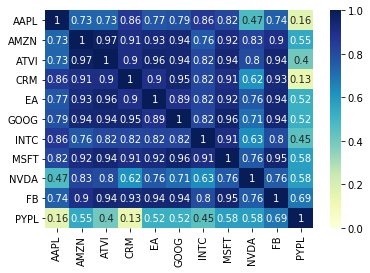

In [26]:
#EXTRA
import seaborn as sns
sns.heatmap(correlation_df.astype('float'), annot=True, vmin=0, vmax=1, cmap="YlGnBu")

## 3.2. Use the price of one stock (lagged at one) as an extra column in your ARMA model

We will now create an extended ARMA model, that will predict the price of a stock B, using as input all 4 features of the ARMA model plus the price of a stock A on the day before.

[**CODE**] Select two stocks A and B and perform an inner join to make sure they are aligned by date. For stock B, compute the inputs to the ARMA model arma_X and arma_y as before. Then, obtain a new matrix arma_cross_X which will have one more column than arma_X and the same number of rows. That extra column should be the price of the stock A (the other stock) with a lag of one, that means the day before. The vector arma_y will continue having the same as before: the price of stock B. Perform linear regression to obtain a model. Measure its error in terms of MSE.

[**REPORT**] Indicate in your report the name of stock A, the name of stock B, and the Pearson's correlation between them. Then, include the obtained MSE of the extended ARMA model with the extra feature in your report, as well as a plot showing the prediction. Compare the results of this extended ARMA model with 5 features against the previous ARMA model that used 4 features, and comment on the results.

In [27]:
def arma_with_support(main_company, support_company, lags):
    print('COMPARATION BETWEEN COMPANIES')
    comp1 = df.loc[df['symbol'] == support_company]
    comp2 = df.loc[df['symbol'] == main_company]
    companies = comp1.set_index('date').join(comp2.set_index('date'), how='inner', lsuffix='_1', rsuffix='_2')

    plt.figure(figsize=(12,4))
    plt.xlabel('Date')
    plt.ylabel('Stock Price [USD]')
    plt.plot_date(companies.index, companies['price_1'], '-', label=support_company)
    plt.plot_date(companies.index, companies['price_2'], '-', label=main_company)
    plt.legend()
    plt.show()
    print("Correlation: %.2f" % stats.pearsonr(companies['price_1'], companies['price_2'])[0])
    
    print('-------------------')

    #create new arma for main_company with the info of the support_company
    new_price_series = companies.loc[companies['symbol_2'] == main_company]

    print('CREATING AR MODEL')
    new_ar_X, new_ar_y = prepare_matrices(new_price_series['price_2'], lags) #[1,2])
    print("Matrix ar_X has %d rows and %d columns" % np.shape(new_ar_X))
    print("Vector ar_y has %d components" % np.shape(new_ar_y)[0])
    assert(len(np.shape(new_ar_y)) == 1) # Check that y is a vector

    new_ar_model = LinearRegression()
    new_ar_model.fit(new_ar_X, new_ar_y)
    new_ar_y_pred = new_ar_model.predict(new_ar_X)
    new_ar_mse = mean_squared_error(new_ar_y_pred, new_ar_y)
    print("MSE of AR model: %.4f" % new_ar_mse)

    print('-------------------')

    new_ar_errors = new_ar_y_pred - new_ar_y
    new_arma_X = []
    new_arma_y = []
    arma_cross_X = []
    for i in range(len(new_ar_X)):
        if i >= 2:
            prev_error = new_ar_errors[i-1]
            prev_prev_error = new_ar_errors[i-2]
            new_arma_X.append([new_ar_X[i][0], new_ar_X[i][1], prev_error, prev_prev_error])
            #Same as new_arma_X but with the historic value of the support yesterday
            arma_cross_X.append([new_ar_X[i][0], new_ar_X[i][1], prev_error, prev_prev_error,
                                 companies['price_1'].values[i-1]])
            new_arma_y.append(new_ar_y[i])

    print('ORIGINAL ARMA MODEL')
    print("Matrix arma_X has %d rows and %d columns" % np.shape(new_arma_X))
    print("Vector arma_y has %d components" % np.shape(new_arma_y)[0])
    assert(len(np.shape(new_arma_y)) == 1) # Check that y is a vector

    new_arma_model = LinearRegression()
    new_arma_model.fit(new_arma_X,new_arma_y)
    new_arma_y_pred = new_arma_model.predict(new_arma_X)
    new_arma_mse = mean_squared_error(new_arma_y_pred, new_arma_y)
    print("MSE of ARMA model: %.4f" % new_arma_mse)

    print('-------------------')

    print('EXTENDED ARMA MODEL INCLUDING THE HISTORIC OF', support_company)
    print("Matrix arma_X has %d rows and %d columns" % np.shape(arma_cross_X))
    print("Vector arma_y has %d components" % np.shape(new_arma_y)[0])
    assert(len(np.shape(new_arma_y)) == 1) # Check that y is a vector

    new_arma_model = LinearRegression()
    new_arma_model.fit(arma_cross_X,new_arma_y)
    new_arma_y_pred = new_arma_model.predict(arma_cross_X)
    historic_new_arma_mse = mean_squared_error(new_arma_y_pred, new_arma_y)
    print("MSE of ARMA model: %.4f" % historic_new_arma_mse)
    print()
    print('RESULT:')
    print('Including', support_company,'in the information of',main_company, 
          'we get an improvement of', new_arma_mse - historic_new_arma_mse)

    plt.figure(figsize=(12,4))
    plt.plot(range(len(new_arma_y)), new_arma_y, '.', label='Actual')
    plt.plot(range(len(new_arma_y_pred)), new_arma_y_pred, '-', label='Predicted with EXTENDED ARMA(2,2) model')
    plt.xlabel('Time step')
    plt.ylabel('Stock price')
    plt.legend()
    plt.show()

COMPARATION BETWEEN COMPANIES


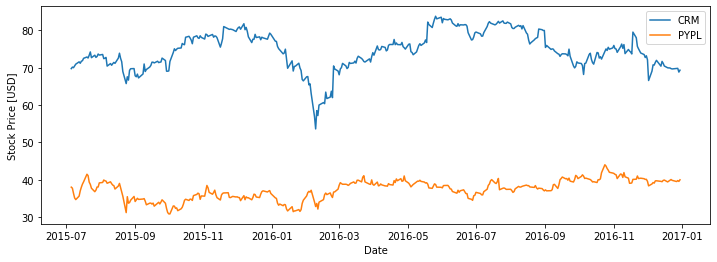

Correlation: 0.13
-------------------
CREATING AR MODEL
Matrix ar_X has 375 rows and 3 columns
Vector ar_y has 375 components
MSE of AR model: 0.6112
-------------------
ORIGINAL ARMA MODEL
Matrix arma_X has 373 rows and 4 columns
Vector arma_y has 373 components
MSE of ARMA model: 0.6087
-------------------
EXTENDED ARMA MODEL INCLUDING THE HISTORIC OF CRM
Matrix arma_X has 373 rows and 5 columns
Vector arma_y has 373 components
MSE of ARMA model: 0.6061

RESULT:
Including CRM in the information of PYPL we get an improvement of 0.002632558663816842


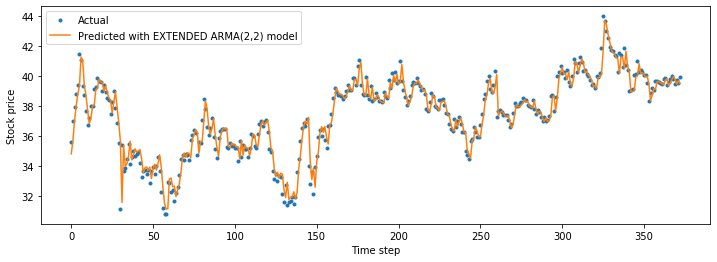

In [28]:
#AAPL,AMZN,EA,NVDA,CRM,MSFT,INTC,GOOG,FB,PYPL,ATVI
main_company = 'PYPL'
support_company = 'CRM'
lags = [1,2,3]
arma_with_support(main_company, support_company, lags)

# 4. Deliver (groups of two)

Deliver:

* A zip file containing your notebook (.ipynb file) with all the [**CODE**] parts implemented.
* A 4-pages PDF report including all parts of this notebook marked with "[**REPORT**]"

The report should end with the following statement: **We hereby declare that, except for the code provided by the course instructors, all of our code, report, and figures were produced by ourselves.**